9860 9860
1861
average_length: 3.4082750228171586
max_length: 6
saving timestamps.....
Found 20028 word vectors.
1861
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 300)       558600      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                         

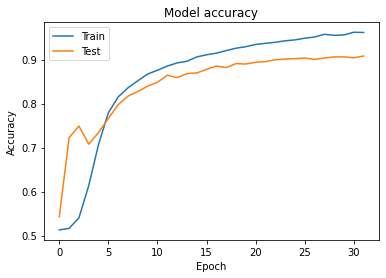

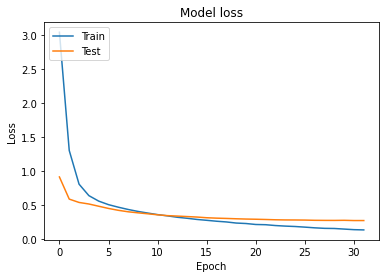

In [ ]:
#!/usr/bin/env python3
# coding: utf-8
# File: siamese_train.py
# Author: lhy<lhy_in_blcu@126.com,https://huangyong.github.io>
# Date: 18-5-23

import numpy as np
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input, Embedding, LSTM, Dropout, Lambda, Bidirectional
import matplotlib.pyplot as plt
import os
from collections import Counter
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

class SiameseNetwork:
    def __init__(self):
        #cur = '/'.join(os.path.abspath(__file__).split('/')[:-1])
        '''self.train_path = os.path.join(cur, '/content/drive/MyDrive/SiameseSentenceSimilarity-master/data/train.txt')
        self.vocab_path = os.path.join(cur, '/content/drive/MyDrive/SiameseSentenceSimilarity-master/model/vocab.txt')
        self.embedding_file = os.path.join(cur, '/content/drive/MyDrive/SiameseSentenceSimilarity-master/model/token_vec_300.bin')
        self.timestamps_file = os.path.join(cur, '/content/drive/MyDrive/SiameseSentenceSimilarity-master/model/timestamps.txt')
        self.model_path = os.path.join(cur, '/content/drive/MyDrive/SiameseSentenceSimilarity-master/model/test.h5')'''

        self.train_path = '/content/drive/MyDrive/SiameseSentenceSimilarity-master/data/相似对语料库train.txt'
        self.vocab_path = '/content/drive/MyDrive/SiameseSentenceSimilarity-master/model/final/vocab.txt'
        self.embedding_file = '/content/drive/MyDrive/SiameseSentenceSimilarity-master/model/token_vec_300.bin'
        self.timestamps_file = '/content/drive/MyDrive/SiameseSentenceSimilarity-master/model/final/timestamps.txt'
        self.model_path = '/content/drive/MyDrive/SiameseSentenceSimilarity-master/model/final/final326.h5'

        self.datas, self.word_dict = self.build_data()
        self.EMBEDDING_DIM = 300
        self.EPOCHS = 32
        #self.BATCH_SIZE = 512
        self.BATCH_SIZE = 256
        #self.NUM_CLASSES = 20
        self.VOCAB_SIZE = len(self.word_dict)
        self.LIMIT_RATE = 0.95
        self.TIME_STAMPS = self.select_best_length()
        self.embedding_matrix = self.build_embedding_matrix()

        print(self.VOCAB_SIZE)

    '''根据样本长度,选择最佳的样本max-length'''
    def select_best_length(self):
        len_list = []
        max_length = 0
        cover_rate = 0.0
        for line in open(self.train_path):
            line = line.strip().split('	')
            if not line:
                continue
            sent = line[0]
            sent_len = len(sent)
            len_list.append(sent_len)
        all_sent = len(len_list)
        sum_length = 0
        len_dict = Counter(len_list).most_common()
        for i in len_dict:
            sum_length += i[1]*i[0]
        average_length = sum_length/all_sent
        for i in len_dict:
            rate = i[1]/all_sent
            cover_rate += rate
            if cover_rate >= self.LIMIT_RATE:
                max_length = i[0]
                break
        print('average_length:', average_length)
        print('max_length:', max_length)
        print('saving timestamps.....')
        f = open(self.timestamps_file, 'w+')
        f.write(str(max_length))
        f.close()
        return max_length

    '''构造数据集'''
    def build_data(self):
        sample_x = []
        sample_y = []
        sample_x_left = []
        sample_x_right = []
        vocabs = {'UNK'}
        for line in open(self.train_path):
            line = line.rstrip().split('\t')
            if not line:
                continue
            if line == ['']:
              continue
            sent_left = line[0]
            sent_right = line[1]
            label = line[2]
            sample_x_left.append([char for char in sent_left if char])
            sample_x_right.append([char for char in sent_right if char])
            sample_y.append(label)
            for char in [char for char in sent_left + sent_right if char]:
                vocabs.add(char)
        print(len(sample_x_left), len(sample_x_right))
        sample_x = [sample_x_left, sample_x_right]
        datas = [sample_x, sample_y]
        word_dict = {wd:index for index, wd in enumerate(list(vocabs))}
        self.write_file(vocabs, self.vocab_path)
        return datas, word_dict

    '''将数据转换成keras所需的格式'''
    def modify_data(self):
        sample_x = self.datas[0]
        sample_y = self.datas[1]
        sample_x_left = sample_x[0]
        sample_x_right = sample_x[1]
        left_x_train = [[self.word_dict[char] for char in data] for data in sample_x_left]
        right_x_train = [[self.word_dict[char] for char in data] for data in sample_x_right]
        y_train = [int(i) for i in sample_y]
        left_x_train = pad_sequences(left_x_train, self.TIME_STAMPS)
        right_x_train = pad_sequences(right_x_train, self.TIME_STAMPS)
        #y_train = np.expand_dims(y_train, 2)###
        y_train = np.expand_dims(y_train,1)
        return left_x_train, right_x_train, y_train

    '''保存字典文件'''
    def write_file(self, wordlist, filepath):
        print(len(wordlist))
        with open(filepath, 'w+') as f:
            for wd in wordlist:
                f.write(wd + '\n')

    '''加载预训练词向量'''
    def load_pretrained_embedding(self):
        embeddings_dict = {}
        with open(self.embedding_file, 'r') as f:
            for line in f:
                values = line.strip().split(' ')
                if len(values) < 300:
                    continue
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_dict[word] = coefs
        print('Found %s word vectors.' % len(embeddings_dict))
        return embeddings_dict

    '''加载词向量矩阵'''
    def build_embedding_matrix(self):
        embedding_dict = self.load_pretrained_embedding()
        embedding_matrix = np.zeros((self.VOCAB_SIZE + 1, self.EMBEDDING_DIM))
        for word, i in self.word_dict.items():
            embedding_vector = embedding_dict.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        return embedding_matrix

    '''基于曼哈顿空间距离计算两个字符串语义空间表示相似度计算'''
    def exponent_neg_manhattan_distance(self, inputX):
        (sent_left, sent_right) = inputX
        return K.exp(-K.sum(K.abs(sent_left - sent_right), axis=1, keepdims=True))

    '''基于欧式距离的字符串相似度计算'''
    def euclidean_distance(self, sent_left, sent_right):
        sum_square = K.sum(K.square(sent_left - sent_right), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_square, K.epsilon()))


    '''搭建编码层网络,用于权重共享'''
    def create_base_network(self, input_shape):
        input = Input(shape=input_shape)
        lstm1 = Bidirectional(LSTM(128, return_sequences=True))(input)
        lstm1 = Dropout(0.5)(lstm1)
        lstm2 = Bidirectional(LSTM(32))(lstm1)
        lstm2 = Dropout(0.5)(lstm2)
        return Model(input, lstm2)

    '''搭建网络'''
    def bilstm_siamese_model(self):
        embedding_layer = Embedding(self.VOCAB_SIZE + 1,
                                    self.EMBEDDING_DIM,
                                    weights=[self.embedding_matrix],
                                    input_length=self.TIME_STAMPS,
                                    trainable=False,
                                    mask_zero=True)

        left_input = Input(shape=(self.TIME_STAMPS,), dtype='float32')
        right_input = Input(shape=(self.TIME_STAMPS,), dtype='float32')

        encoded_left = embedding_layer(left_input)
        encoded_right = embedding_layer(right_input)

        shared_lstm = self.create_base_network(input_shape=(self.TIME_STAMPS, self.EMBEDDING_DIM))
        left_output = shared_lstm(encoded_left)
        right_output = shared_lstm(encoded_right)
        distance = Lambda(self.exponent_neg_manhattan_distance)([left_output, right_output])
        model = Model([left_input, right_input], distance)
        model.compile(loss='binary_crossentropy',
                      optimizer='nadam',
                      metrics=['accuracy'])
        model.summary()
        return model


    '''训练模型'''
    def train_model(self):
        left_x_train, right_x_train, y_train = self.modify_data()
        model = self.bilstm_siamese_model()
        history = model.fit(
                              x=[left_x_train, right_x_train],
                              y=y_train,
                              validation_split=0.2,
                              batch_size=self.BATCH_SIZE,
                              epochs=self.EPOCHS,
                            )
        self.draw_train(history)
        model.save_weights(self.model_path)
        return model

    '''绘制训练曲线'''
    def draw_train(self, history):
        print(history.history['loss'])
        print(history.history['val_loss'])
        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
        #
        # # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()


if __name__ == '__main__':
    handler = SiameseNetwork()
    model = handler.train_model()

In [ ]:
#!/usr/bin/env python3
# coding: utf-8
# File: siamese_train.py
# Author: lhy<lhy_in_blcu@126.com,https://huangyong.github.io>
# Date: 18-5-23

import numpy as np
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input, Embedding, LSTM, Dropout, Lambda, Bidirectional
import os
from collections import Counter
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

class SiameseNetwork:
    def __init__(self):
        self.train_path = '/content/drive/MyDrive/SiameseSentenceSimilarity-master/data/相似对语料库train.txt'
        self.vocab_path = '/content/drive/MyDrive/SiameseSentenceSimilarity-master/model/final/vocab.txt'
        self.embedding_file = '/content/drive/MyDrive/SiameseSentenceSimilarity-master/model/token_vec_300.bin'
        self.timestamps_file = '/content/drive/MyDrive/SiameseSentenceSimilarity-master/model/final/timestamps.txt'
        self.model_path = '/content/drive/MyDrive/SiameseSentenceSimilarity-master/model/final/final326.h5'
        
        self.word_dict = self.load_worddict()
        self.EMBEDDING_DIM = 300
        self.EPOCHS = 32
        self.BATCH_SIZE = 256
        #self.NUM_CLASSES = 20
        self.VOCAB_SIZE = len(self.word_dict)
        self.LIMIT_RATE = 0.95
        self.TIME_STAMPS = self.load_timestamps()
        self.embedding_matrix = self.build_embedding_matrix()
        self.model = self.load_siamese_model()

    '''加载timestamps'''
    def load_timestamps(self):
        timestamps = [i.strip() for i in open(self.timestamps_file) if i.strip()][0]
        return int(timestamps)

    '''加载词典'''
    def load_worddict(self):
        vocabs = [i.replace('\n','') for i in open(self.vocab_path)]
        word_dict = {wd: index for index, wd in enumerate(vocabs)}
        print(len(vocabs))
        return word_dict

    '''对输入的文本进行处理'''
    def represent_sent(self, s):
        wds = [char for char in s if char]
        sent = [[self.word_dict[char] for char in wds]]
        sent_rep = pad_sequences(sent, self.TIME_STAMPS)
        return sent_rep

    '''加载预训练词向量'''
    def load_pretrained_embedding(self):
        embeddings_dict = {}
        with open(self.embedding_file, 'r') as f:
            for line in f:
                values = line.strip().split(' ')
                if len(values) < 300:
                    continue
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_dict[word] = coefs
        print('Found %s word vectors.' % len(embeddings_dict))
        return embeddings_dict

    '''加载词向量矩阵'''
    def build_embedding_matrix(self):
        embedding_dict = self.load_pretrained_embedding()
        embedding_matrix = np.zeros((self.VOCAB_SIZE + 1, self.EMBEDDING_DIM))
        for word, i in self.word_dict.items():
            embedding_vector = embedding_dict.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        return embedding_matrix

    def exponent_neg_manhattan_distance(self, inputX):
        (sent_left, sent_right) = inputX
        return K.exp(-K.sum(K.abs(sent_left - sent_right), axis=1, keepdims=True))

    '''基于欧式距离的字符串相似度计算'''
    def euclidean_distance(self, sent_left, sent_right):
        sum_square = K.sum(K.square(sent_left - sent_right), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_square, K.epsilon()))


    '''搭建编码层网络,用于权重共享'''
    def create_base_network(self, input_shape):
        input = Input(shape=input_shape)
        lstm1 = Bidirectional(LSTM(128, return_sequences=True))(input)
        lstm1 = Dropout(0.5)(lstm1)
        lstm2 = Bidirectional(LSTM(32))(lstm1)
        lstm2 = Dropout(0.5)(lstm2)
        return Model(input, lstm2)

    '''搭建网络'''
    def bilstm_siamese_model(self):
        embedding_layer = Embedding(self.VOCAB_SIZE + 1,
                                    self.EMBEDDING_DIM,
                                    weights=[self.embedding_matrix],
                                    input_length=self.TIME_STAMPS,
                                    trainable=False,
                                    mask_zero=True)

        left_input = Input(shape=(self.TIME_STAMPS,), dtype='float32')
        right_input = Input(shape=(self.TIME_STAMPS,), dtype='float32')

        encoded_left = embedding_layer(left_input)
        encoded_right = embedding_layer(right_input)

        shared_lstm = self.create_base_network(input_shape=(self.TIME_STAMPS, self.EMBEDDING_DIM))
        left_output = shared_lstm(encoded_left)
        right_output = shared_lstm(encoded_right)

        distance = Lambda(self.exponent_neg_manhattan_distance)([left_output, right_output])
        model = Model([left_input, right_input], distance)
        model.compile(loss='binary_crossentropy',
                      optimizer='nadam',
                      metrics=['accuracy'])
        model.summary()
        return model

    '''使用模型'''
    def load_siamese_model(self):
        model = self.bilstm_siamese_model()
        model.load_weights(self.model_path)

        return model

    '''使用模型进行预测'''
    def predict(self, s1, s2):
        rep_s1 = self.represent_sent(s1)
        rep_s2 = self.represent_sent(s2)
        #res = self.model.predict([rep_s1, rep_s2])
        res = model.predict([rep_s1, rep_s2])
        return res

    '''测试模型'''
    def test(self,s1,s2):
        #s1 = '口燥'
        #s2 = '口干舌燥'
        res = self.predict(s1, s2)
        #print(res)
        return res


handler = SiameseNetwork()
#handler.test()

1861
Found 20028 word vectors.
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 6, 300)       558600      ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 model_4 (Functional)           (None, 64)           513280  

In [ ]:
result=[]
for line in open('/content/drive/MyDrive/SiameseSentenceSimilarity-master/data/相似对语料库test.txt'):
  line = line.rstrip().split('\t')
  if line == ['']:
    continue
  print(line)
  s1 = line[0]
  s2 = line[1]
  all = list(s1 + s2)
  flag = 1
  for i in all:
    if i not in handler.word_dict:
      flag = 0
      break
  if flag == 0:
    result.append([line,0])
  elif flag == 1:
    result.append([line,handler.test(s1,s2)[0][0]])

['眩冒', '眩晕', '1']
['腹泻', '拉肚子', '1']
['面游风', '白屑风', '1']
['蜈蚣咬伤', '心烦胁痛', '0']
['利痰', '初时如葡萄', '0']
['瘴气成块', '洗目中翳障', '0']
['郁咳', '火咳', '1']
['狐瘕', '症瘕', '1']
['咳嗽', '都', '1']
['红丝疔', '紫疥斑', '1']
['脑渗', '控脑砂', '1']
['耳根痛', '耳根痈', '1']
['老疟劳疟', '不可转侧', '0']
['久有瘀血', '头忽晕眩', '0']
['男子失精', '退热', '0']
['久咳', '脐腹积聚疼痛', '0']
['肺热证', '肺虚热', '1']
['不能行走', '有脓无头', '0']
['热', '发热', '1']
['窜视', '昼夜不止', '0']
['去浮肿', '消渴', '0']
['妇女阴寒', '年老或体虚的病人', '0']
['心上坚硬', '咽喉为谷物芒刺所伤', '0']
['痰秘', '便秘', '1']
['眼睛昏花不明', '头痛流涕', '0']
['粗糙呼吸音', '咽喉部有吱吱声', '1']
['稀便', '大便奶瓣稀', '1']
['妊妇腹痛吐酸', '坐卧不得', '0']
['血如泉涌', '久嗽痰喘', '0']
['即肺结核', '使人神志清明', '0']
['病人喜食土和某些生物', '产后流血过少', '0']
['太似伤寒', '病久体弱', '0']
['中毒烦闷', '脉大', '0']
['补肾', '不拘生胎死胎', '0']
['脚心痈', '涌泉疽', '1']
['口舌糜疮', '蜘蛛', '0']
['呼吸道感染', '消化不良', '1']
['发热', '是上呼吸道感染', '1']
['普通感冒', '一感', '1']
['蟠肠气', '疝', '1']
['肾虚头痛', '头痛', '1']
['腿痈', '大腿痈', '1']
['肺水', '水肿', '1']
['伤寒时气', '肾囊肿大', '0']
['冷疮', '冷痿', '1']
['发热', '脑炎', '1']
['肾囊风', '绣球风', '1']
['吐血咳血', '阴毒欲死',

In [ ]:
gold=[]
pre=[]
for i in result:
  gold.append(int(i[0][-1]))
  if i[1]>=0.7:
    pre.append(1)
  else:
    pre.append(0)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(gold,pre))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1269
           1       0.95      0.82      0.88      1196

    accuracy                           0.89      2465
   macro avg       0.90      0.89      0.89      2465
weighted avg       0.89      0.89      0.89      2465



In [ ]:
import json

In [ ]:
log=[]
for i in result:
  log.append([i[0],str(i[1])])

In [ ]:
filename='/content/drive/MyDrive/SiameseSentenceSimilarity-master/data/test_log.json'
with open(filename,'w',encoding='utf-8') as file_obj:
    json.dump(log,file_obj,ensure_ascii=False,indent = 4)